In [2]:
library(Seurat)
library(ggplot2)
library(rhdf5)
library(dplyr)
library(glue)
library(Signac)

Attaching SeuratObject


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'glue'


The following object is masked from 'package:dplyr':

    collapse




In [172]:
options(repr.plot.width=8, repr.plot.height=8)

In [194]:
qc_df <- read.table("/lab/work/vivekrai/2021-06_pilot-rfx6/work/nuclei-qc/metrics_allcols-barcodes_post-qc.txt",
                    sep = " ", header = T)

In [195]:
head(qc_df)

,Sample,Barcode,tss_enrichment,percent_hqaa,hqaa,total_reads.x,total_autosomal_reads,percent_mitochondrial,percent_autosomal_duplicate,percent_duplicate,⋯,fraction_mitochondrial,RD.UNIQ,ATAC_SNG.1ST,ATAC_PRB.SNG1,ATAC_Demux,RNA_SNG.1ST,RNA_PRB.SNG1,RNA_Demux,Pass_QC,Demux_both
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<lgl>,<chr>
1,3528_CV1,AAACCGCCATGAGGAG,2.005676,59.02611,9358,15854,13380,3.86653211,28.14649,26.61789,⋯,0.0002261420,1036,1_16191825-ND-25yM-SC,1,SNG,1_16191825-ND-25yM-SC,1,SNG,TRUE,SNG
2,3528_CV1,AAACCGGTCGACATTT,3.588559,54.55690,243021,445445,360820,0.32102729,31.41650,26.98650,⋯,0.0042019276,22830,5_AHKI007-HPAP074,1,SNG,5_AHKI007-HPAP074,1,SNG,TRUE,SNG
3,3528_CV1,AAACGAACAGGTTATG,3.427703,59.92290,129180,215577,188392,0.30429962,30.24226,27.96495,⋯,0.0002675585,12841,1_16191825-ND-25yM-SC,1,SNG,1_16191825-ND-25yM-SC,1,SNG,TRUE,SNG
4,3528_CV1,AAACTAGTCTCAGCTA,4.243854,61.97339,86513,139597,127301,0.03868278,30.96205,29.69763,⋯,0.0002809419,8199,3_16550021-ND-50yF-SC,1,SNG,3_16550021-ND-50yF-SC,1,SNG,TRUE,SNG
5,3528_CV1,AAACTCGCACGATTCT,3.875486,57.81155,98571,170504,144877,0.26509642,30.77300,27.63513,⋯,0.0025662366,9330,5_AHKI007-HPAP074,1,SNG,5_AHKI007-HPAP074,1,SNG,TRUE,SNG
6,3528_CV1,AAACTCGCACTTCAAC,3.191812,55.78079,76828,137732,111315,7.60317138,29.29614,28.11620,⋯,0.0015222416,7826,5_AHKI007-HPAP074,1,SNG,5_AHKI007-HPAP074,1,SNG,TRUE,SNG


In [246]:
protein_coding_genes <- rtracklayer::readGFF("/lab/work/vivekrai/2021-06_pilot-rfx6/data/reference/hg19-mCherry-mKate2_protein-coding_genes.gtf") %>%
    filter(!seqid %in% c("chrY", "chrM")) %>%
    mutate(seqid = forcats::fct_drop(seqid))

In [ ]:
dim(protein_coding_genes)

In [331]:
protein_coding_genes %>% filter(gene_name %in% c("INS", "INS-IGF2", "SST", "GCG", "PRSS1", "GHRL", "COL6A1"))

seqid,source,type,start,end,score,strand,phase,gene_id,transcript_id,gene_type,gene_status,gene_name,transcript_type,transcript_status,transcript_name,level,tag,havana_gene,gene_biotype
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr11,HAVANA,gene,2153768,2182439,NA,-,NA,ENSG00000129965.9,ENSG00000129965.9,protein_coding,KNOWN,INS-IGF2,protein_coding,KNOWN,INS-IGF2,2,ncRNA_host,OTTHUMG00000166213.1,NA
chr11,HAVANA,gene,2181009,2182571,NA,-,NA,ENSG00000254647.2,ENSG00000254647.2,protein_coding,KNOWN,INS,protein_coding,KNOWN,INS,2,NA,OTTHUMG00000009558.8,NA
chr2,HAVANA,gene,162999392,163008914,NA,-,NA,ENSG00000115263.10,ENSG00000115263.10,protein_coding,KNOWN,GCG,protein_coding,KNOWN,GCG,2,NA,OTTHUMG00000153892.3,NA
chr21,HAVANA,gene,47401651,47424964,NA,+,NA,ENSG00000142156.10,ENSG00000142156.10,protein_coding,KNOWN,COL6A1,protein_coding,KNOWN,COL6A1,2,NA,OTTHUMG00000090440.1,NA
chr3,HAVANA,gene,10327359,10334631,NA,-,NA,ENSG00000157017.11,ENSG00000157017.11,protein_coding,KNOWN,GHRL,protein_coding,KNOWN,GHRL,2,NA,OTTHUMG00000155360.3,NA
chr3,HAVANA,gene,187386694,187388187,NA,-,NA,ENSG00000157005.3,ENSG00000157005.3,protein_coding,KNOWN,SST,protein_coding,KNOWN,SST,2,NA,OTTHUMG00000156462.1,NA
chr7,HAVANA,gene,142457319,142460923,NA,+,NA,ENSG00000204983.8,ENSG00000204983.8,protein_coding,KNOWN,PRSS1,protein_coding,KNOWN,PRSS1,1,NA,OTTHUMG00000158923.2,NA


# Clustering using RNA modality

## Load data

In [9]:
RNA_HDFS <- Sys.glob("/lab/work/vivekrai/2021-06_pilot-rfx6/work/nuclei-qc/rna/*.hdf5")

In [306]:
load_hdf <- function(HDF) {
    tmp <- h5ls(HDF)
    GROUP <- paste("/", tmp$name[tmp$group=='/'], sep='')
    df <- h5read(HDF, GROUP, native = F, compoundAsDataFrame=T)
    counts <- t(df$block0_values)
    rownames(counts) <- as.character(df$axis1)
    colnames(counts) <- as.character(df$axis0)
    counts <- counts[, colnames(counts) %in% protein_coding_genes$gene_name]
    print("INS" %in% colnames(counts))
    return(counts)
}

In [312]:
rna_objects <- list()

for (f in RNA_HDFS) {
    rna_counts <- load_hdf(f)

    library <- unlist(lapply(strsplit(rownames(rna_counts), '-'), function(x){x[1]}))

    metadata <- data.frame(library = library, nucleus = rownames(rna_counts))
    rownames(metadata) <- metadata$nucleus

    rna <- CreateSeuratObject(
        counts = t(rna_counts),
        min.cells = 1,
        assay = "RNA",
        project = as.character(unique(metadata$library)[1]),
        metadata = metadata
    )
    rna$tech <- "rna"
    rna$library <- metadata$library
    rna_objects[[length(rna_objects) + 1]] <- rna
}

if (length(rna_objects) > 1) {
    rna_additional <- c()
    for (i in 2:length(rna_objects)) {
     rna_additional <- c(rna_additional, rna_objects[[i]])
    }
    rna <- merge(rna_objects[[1]], y = rna_additional, project = "RNA")
} else {
    rna <- rna_objects[[1]]
}

[1] TRUE


Warning message:
"The following arguments are not used: row.names"


[1] TRUE


Warning message:
"The following arguments are not used: row.names"


In [330]:
head(rna)

,orig.ident,nCount_RNA,nFeature_RNA,tech,library,RNA_snn_res.0.3,seurat_clusters
,<chr>,<dbl>,<int>,<chr>,<chr>,<fct>,<fct>
3528_CV1-AAACCAACACCCACCT,3528,5031,2687,rna,3528_CV1,6,6
3528_CV1-AAACCGCGTGCGCAAT,3528,5393,2487,rna,3528_CV1,0,0
3528_CV1-AAACCGGCAGGCGAGT,3528,4185,2302,rna,3528_CV1,1,1
3528_CV1-AAAGCAAGTTGGATAT,3528,5029,2437,rna,3528_CV1,0,0
3528_CV1-AAAGCTTGTGAATCGC,3528,7043,2987,rna,3528_CV1,1,1
3528_CV1-AAATGCCTCAAGACTC,3528,5559,2678,rna,3528_CV1,3,3
3528_CV1-AACAGCAAGTCATTGA,3528,2848,1755,rna,3528_CV1,1,1
3528_CV1-AACCGCTCAGTTTCTC,3528,10116,3847,rna,3528_CV1,0,0
3528_CV1-AACCGCTCATTGTGCA,3528,6066,3029,rna,3528_CV1,4,4


## Clustering each library separately

In [174]:
cluster_library <- function(obj, dims = 1:50, resolution = 0.3) {
    rna_1 <- obj
    rna_1 <- NormalizeData(rna_1)
    rna_1 <- FindVariableFeatures(rna_1)
    rna_1 <- ScaleData(rna_1)
    rna_1 <- RunPCA(rna_1, npcs=100, verbose=F)
    rna_1 <- FindNeighbors(rna_1, dims = dims)
    rna_1 <- FindClusters(rna_1, resolution = resolution)
    rna_1 <- RunUMAP(rna_1, reduction='pca', dims = dims, verbose = F)
}

In [175]:
rna_lib_1 <- cluster_library(rna_objects[[1]])

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1065
Number of edges: 41261

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9002
Number of communities: 7
Elapsed time: 0 seconds


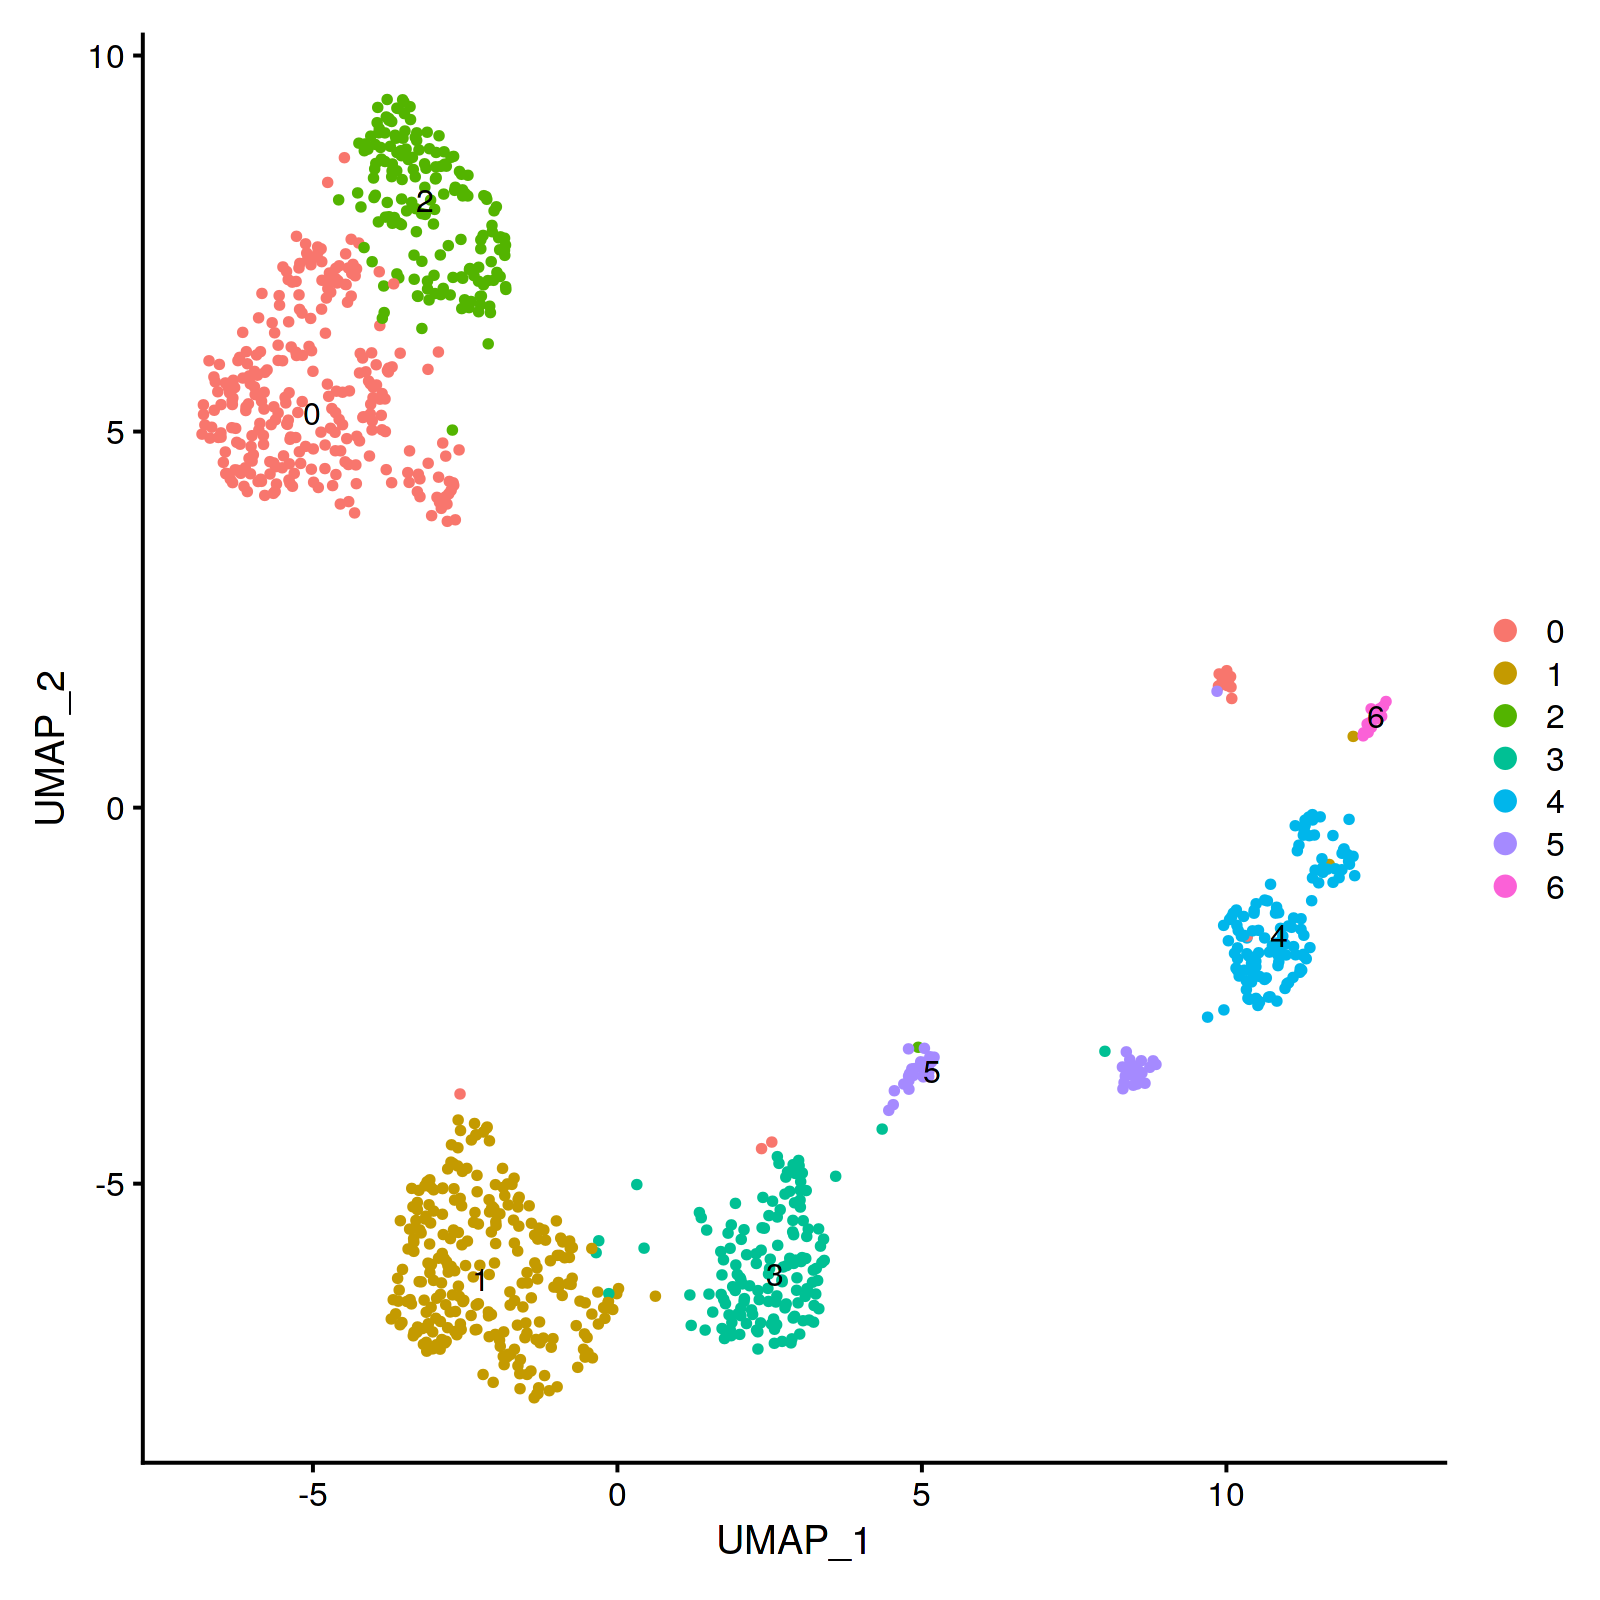

In [176]:
DimPlot(rna_lib_1, reduction = "umap", label = TRUE)

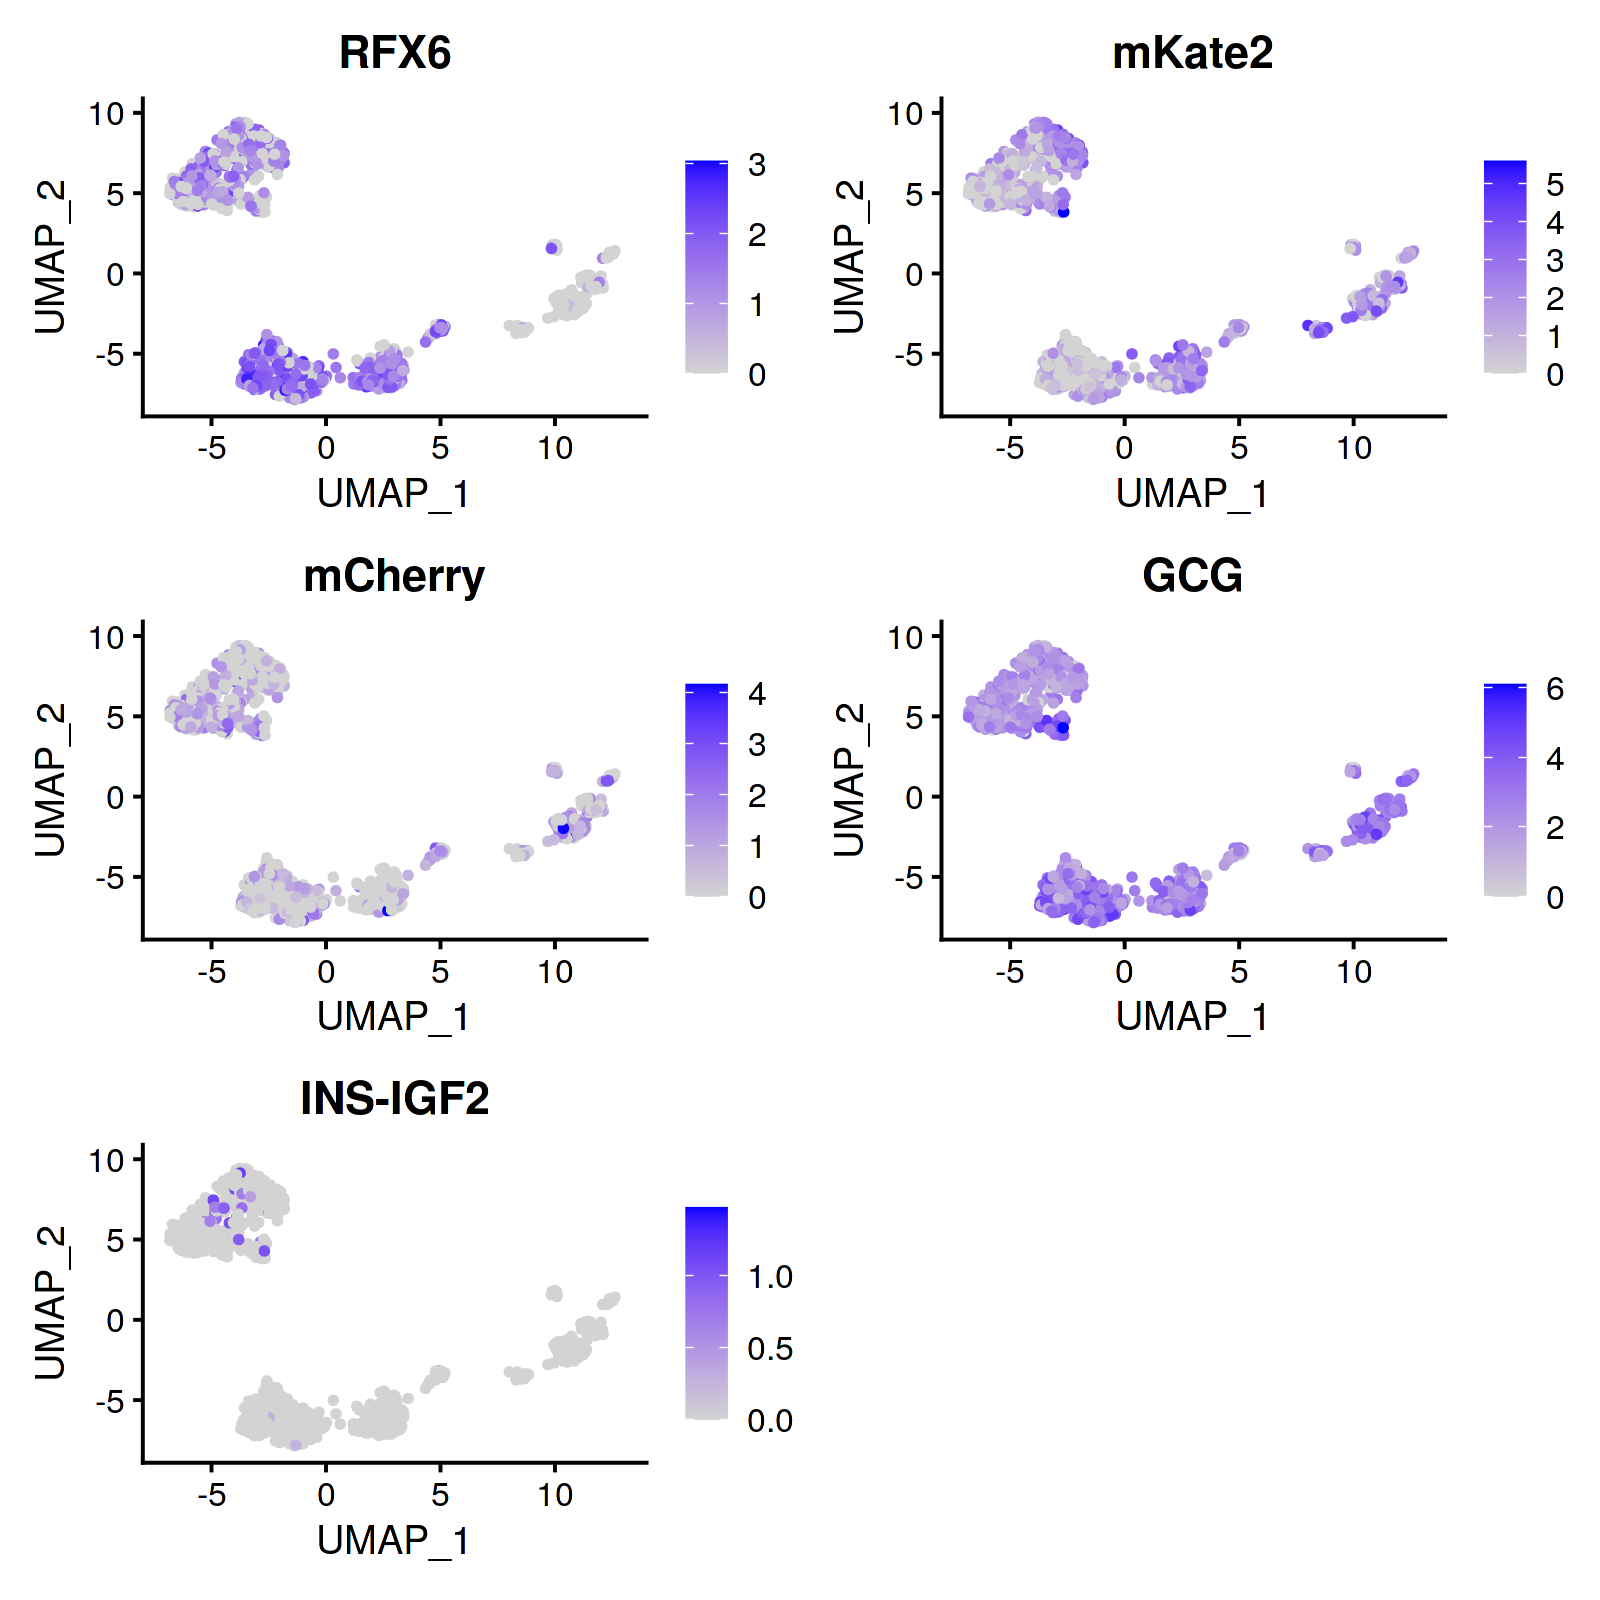

In [177]:
FeaturePlot(rna_lib_1, c("RFX6", "mKate2", "mCherry", "GCG", "INS-IGF2"), )

In [178]:
rna_lib_2 <- cluster_library(rna_objects[[2]])

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1559
Number of edges: 63950

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9009
Number of communities: 6
Elapsed time: 0 seconds


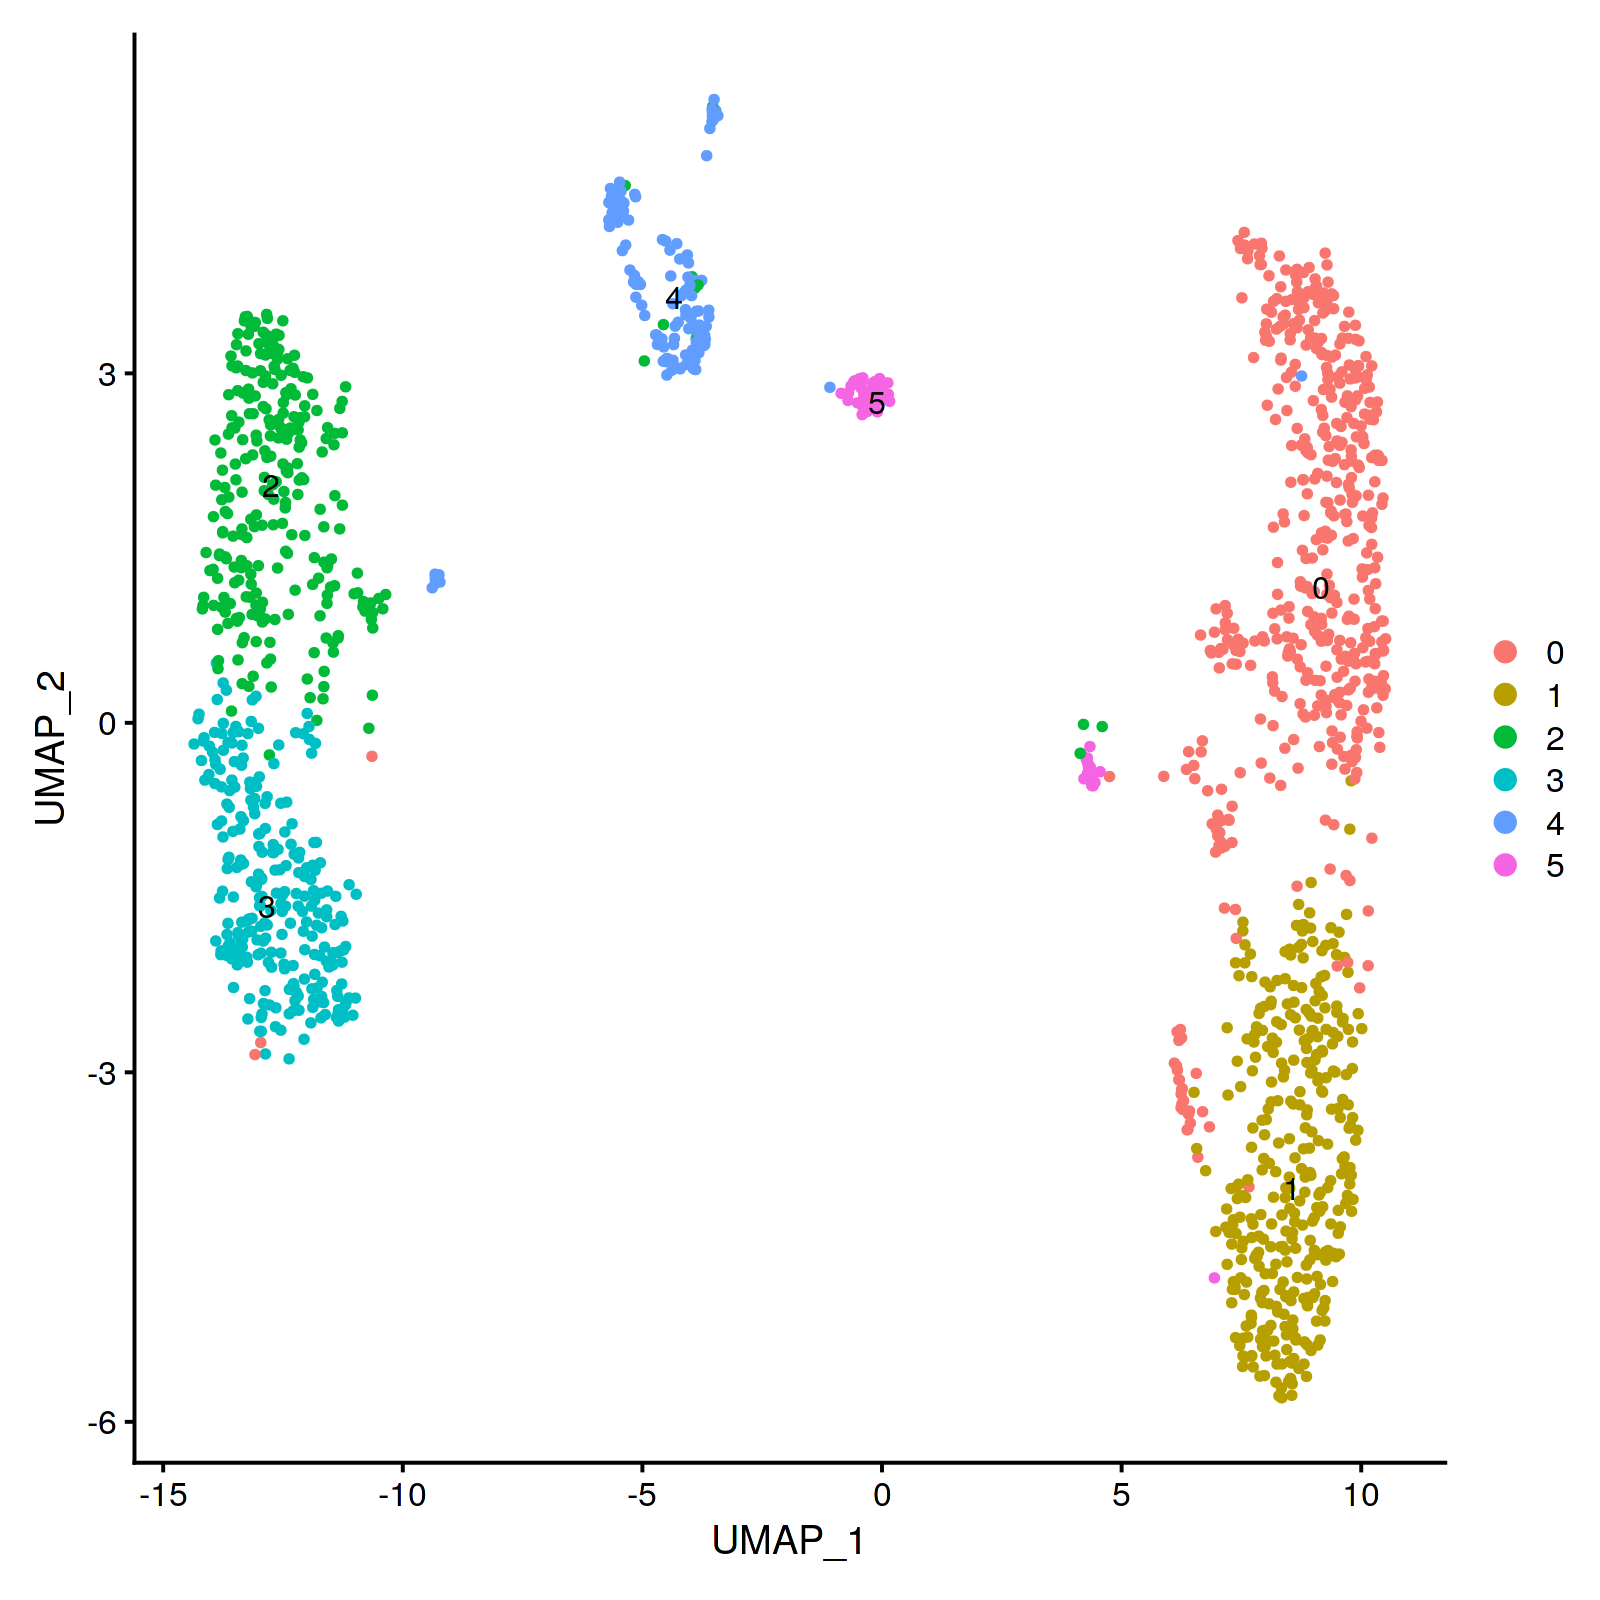

In [179]:
DimPlot(rna_lib_2, reduction = "umap", label = TRUE)

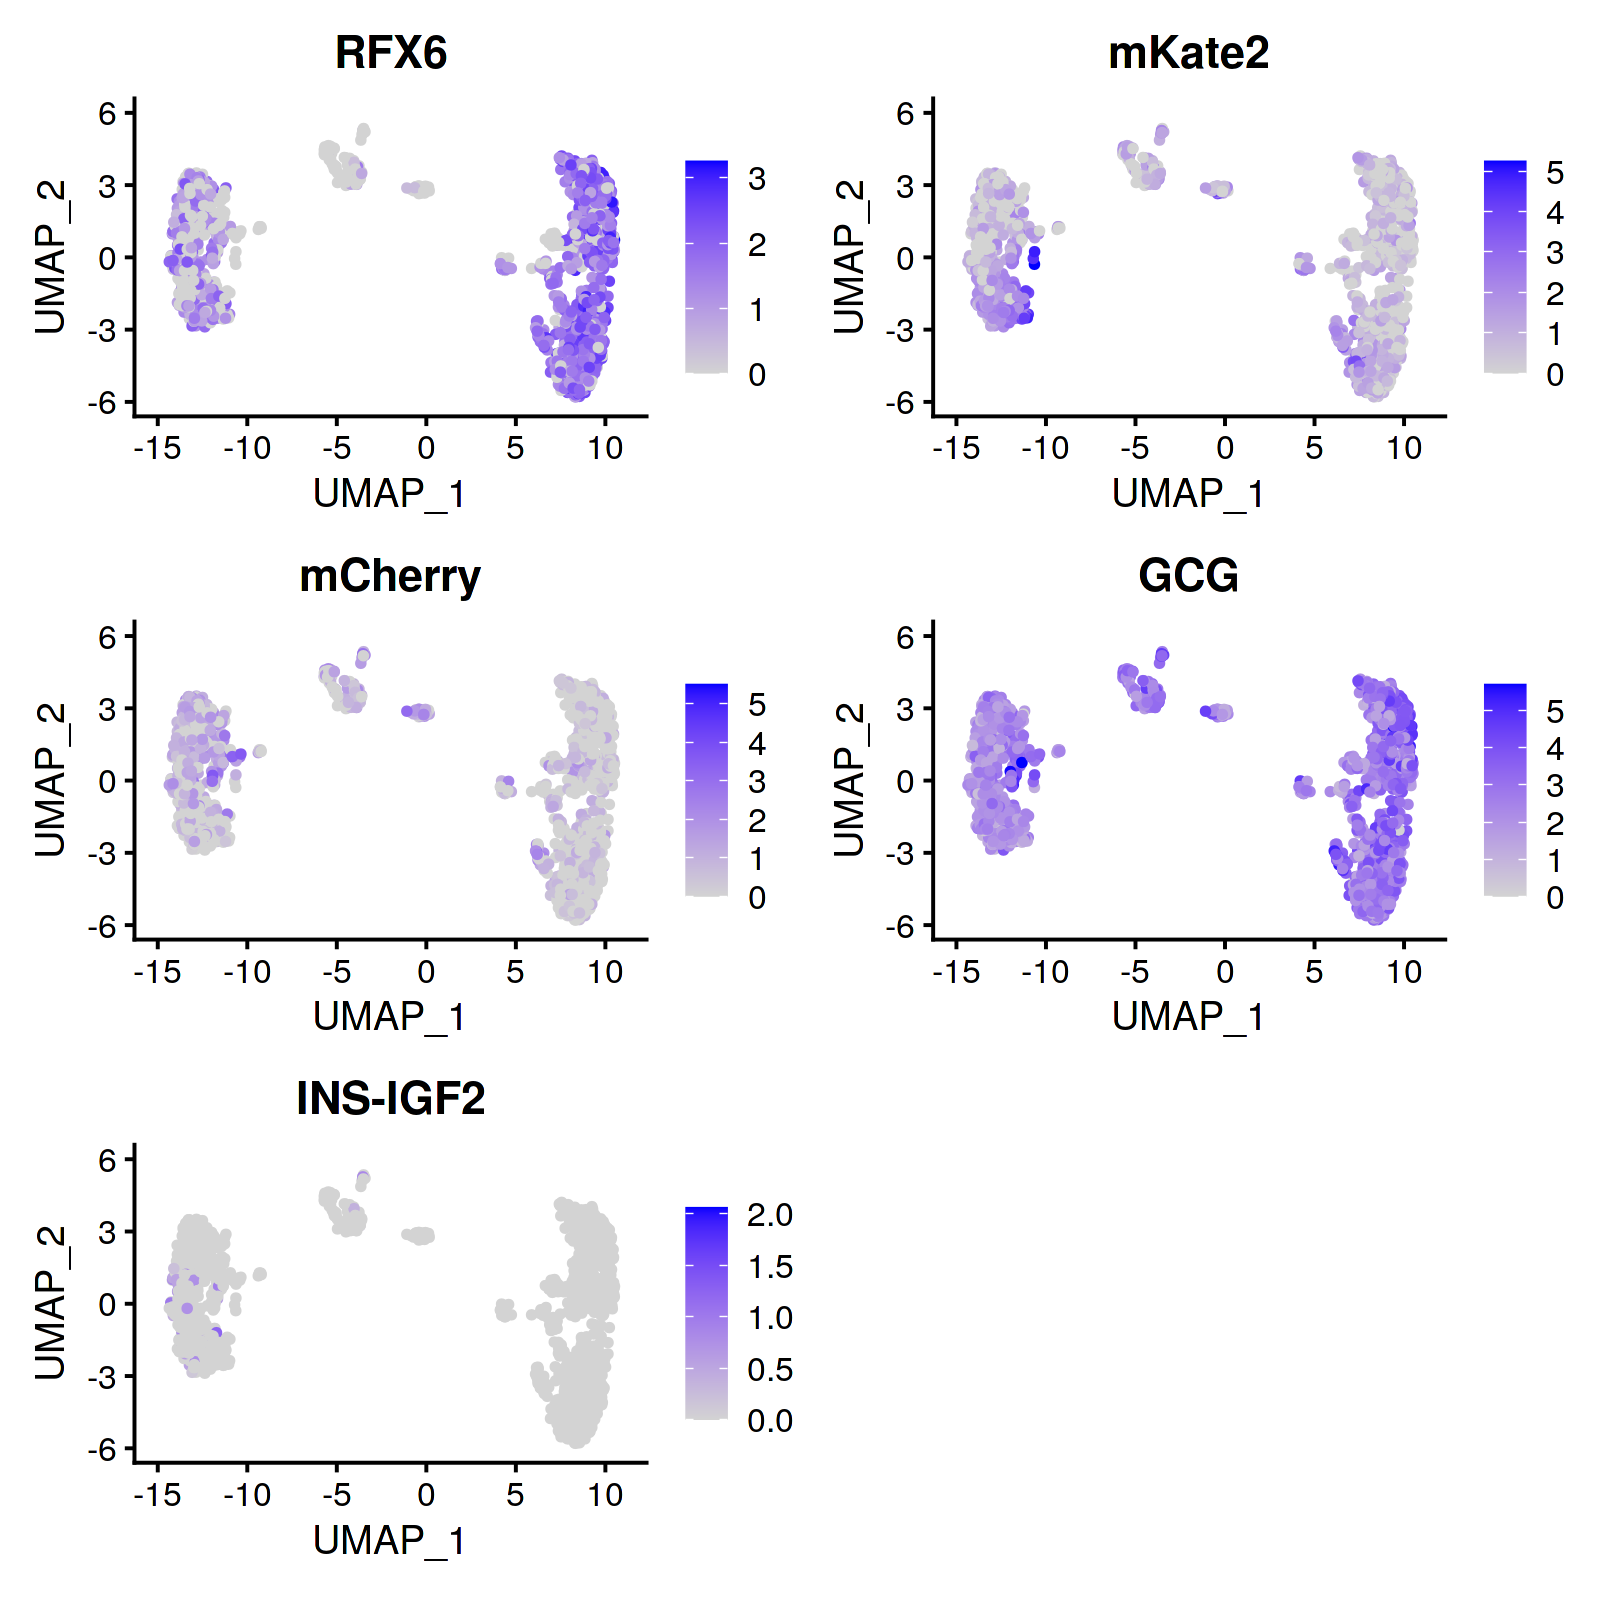

In [180]:
FeaturePlot(rna_lib_2, c("RFX6", "mKate2", "mCherry", "GCG", "INS-IGF2"), )

In [277]:
?FindVariableFeatures

FindVariableFeatures {Seurat},R Documentation
object,An object
...,Arguments passed to other methods
selection.method,"How to choose top variable features. Choose one of : vst: First, fits a line to the relationship of log(variance) and log(mean) using local polynomial regression (loess). Then standardizes the feature values using the observed mean and expected variance (given by the fitted line). Feature variance is then calculated on the standardized values after clipping to a maximum (see clip.max parameter). mean.var.plot (mvp): First, uses a function to calculate average expression (mean.function) and dispersion (dispersion.function) for each feature. Next, divides features into num.bin (deafult 20) bins based on their average expression, and calculates z-scores for dispersion within each bin. The purpose of this is to identify variable features while controlling for the strong relationship between variability and average expression. dispersion (disp): selects the genes with the highest dispersion values"
loess.span,(vst method) Loess span parameter used when fitting the variance-mean relationship
clip.max,(vst method) After standardization values larger than clip.max will be set to clip.max; default is 'auto' which sets this value to the square root of the number of cells
mean.function,Function to compute x-axis value (average expression). Default is to take the mean of the detected (i.e. non-zero) values
dispersion.function,Function to compute y-axis value (dispersion). Default is to take the standard deviation of all values
num.bin,Total number of bins to use in the scaled analysis (default is 20)
binning.method,"Specifies how the bins should be computed. Available methods are: equal_width: each bin is of equal width along the x-axis [default] equal_frequency: each bin contains an equal number of features (can increase statistical power to detect overdispersed features at high expression values, at the cost of reduced resolution along the x-axis)"
verbose,show progress bar for calculations


## Cluster together

In [316]:
rna <- NormalizeData(rna)
rna <- FindVariableFeatures(rna, nfeatures = 2000)
rna <- ScaleData(rna)
rna <- RunPCA(rna, npcs = 100, verbose = F)

Centering and scaling data matrix



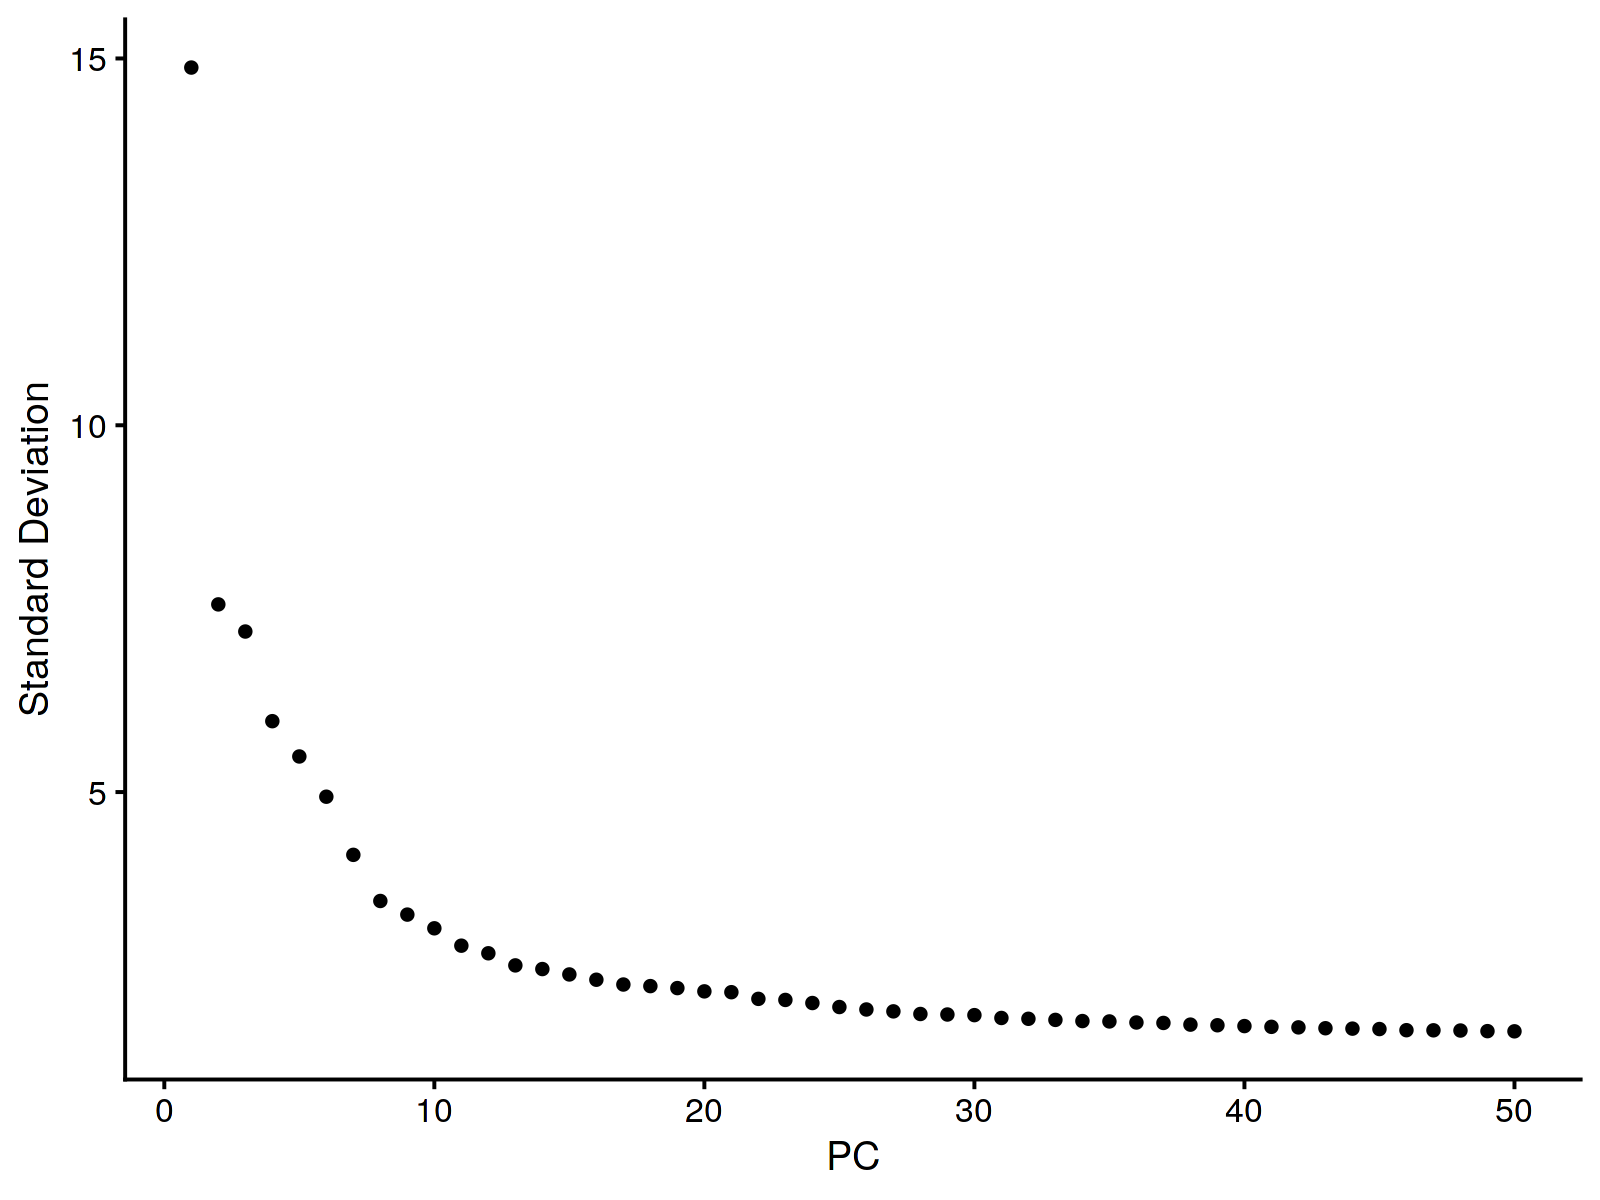

In [317]:
ElbowPlot(rna, ndims = 50)

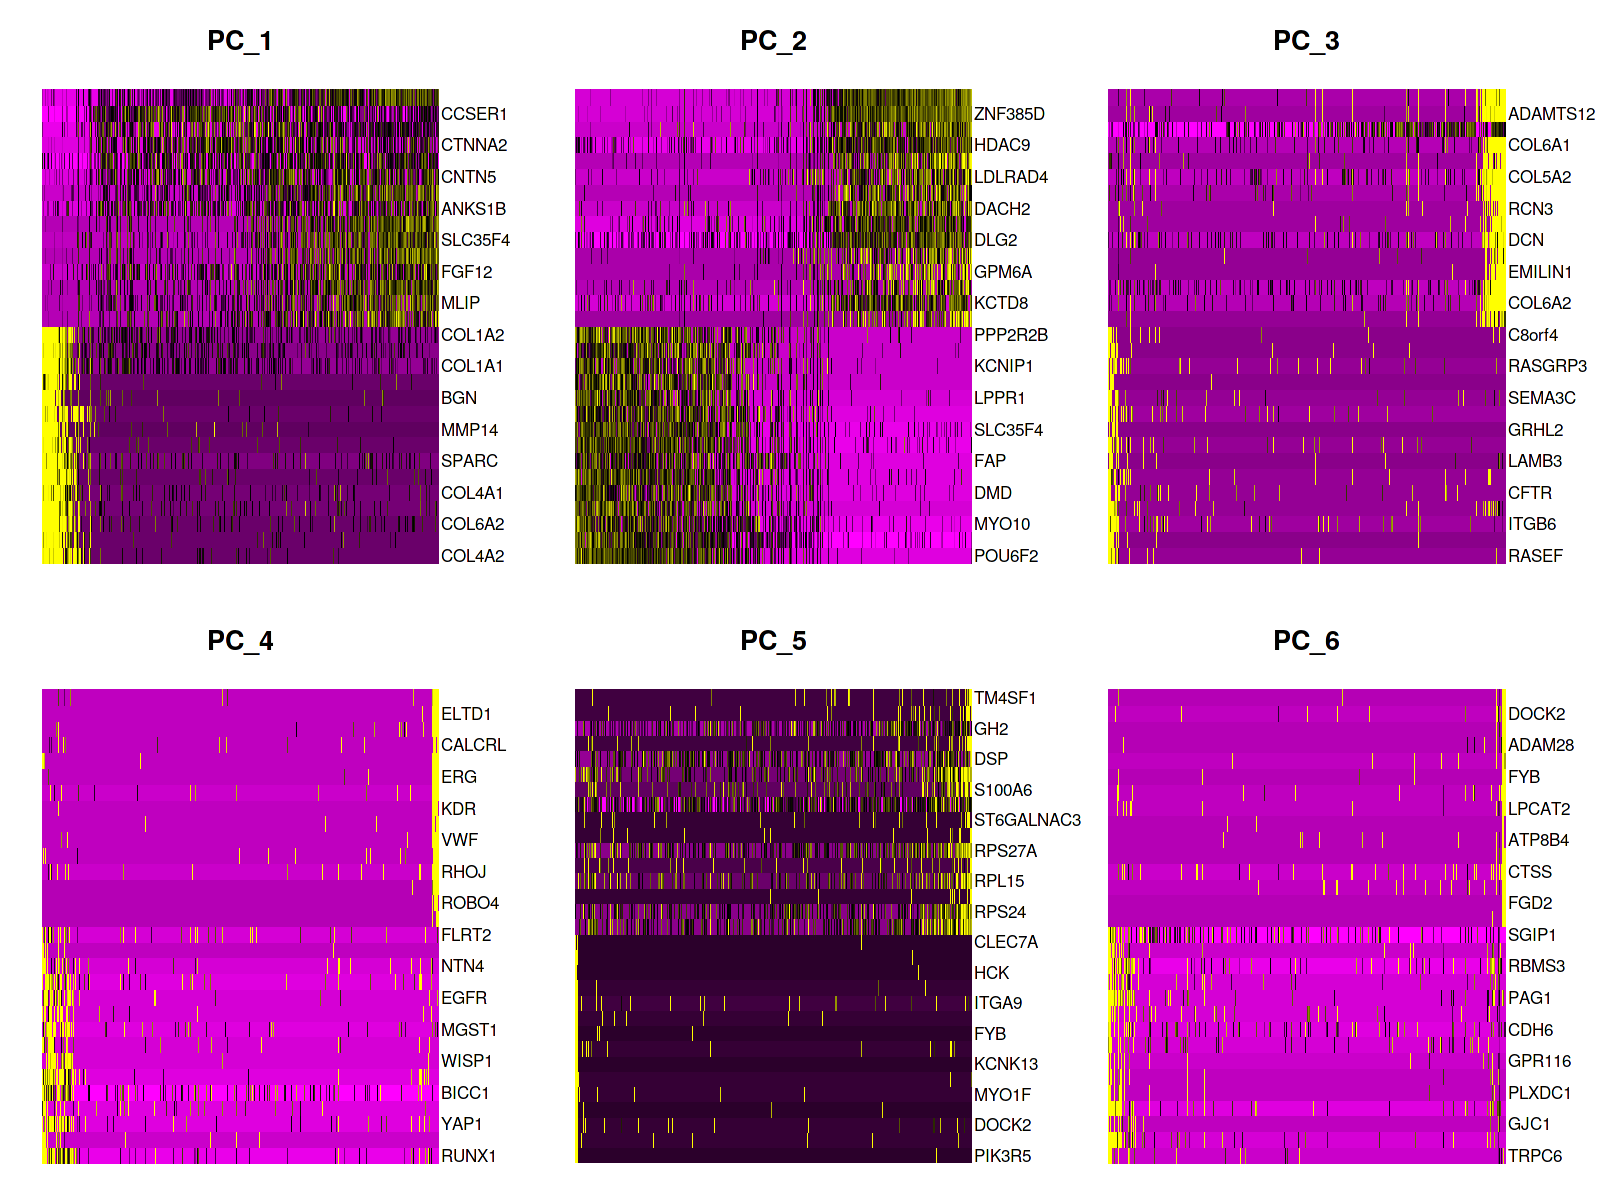

In [318]:
PCHeatmap(object = rna, dims = 1:6)

In [319]:
rna <- FindNeighbors(rna, dims = 1:20)
rna <- RunUMAP(rna, reduction = 'pca', dims = 1:20, verbose = F)

Computing nearest neighbor graph

Computing SNN



In [320]:
rna <- FindClusters(rna, resolution = 0.3)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2624
Number of edges: 93679

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9014
Number of communities: 11
Elapsed time: 0 seconds


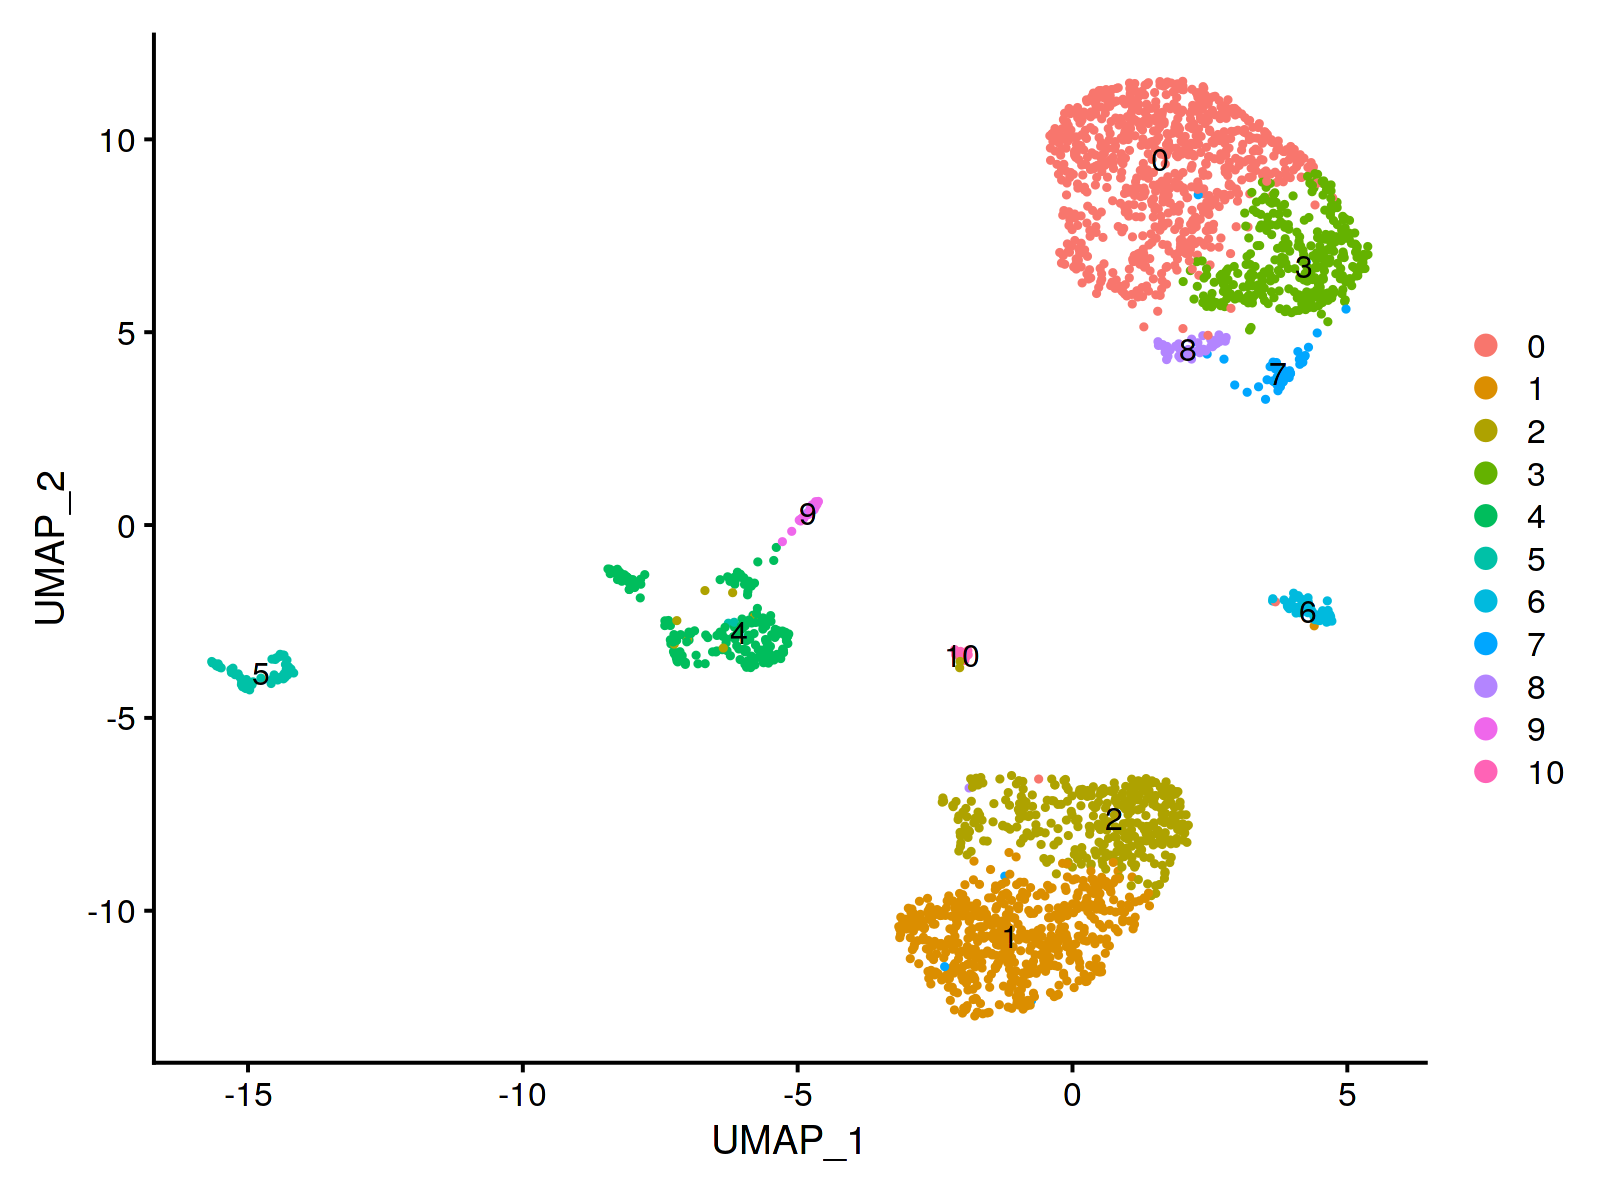

In [321]:
DimPlot(rna, reduction = "umap", label = TRUE)

In [329]:
rna

An object of class Seurat 
17240 features across 2624 samples within 1 assay 
Active assay: RNA (17240 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

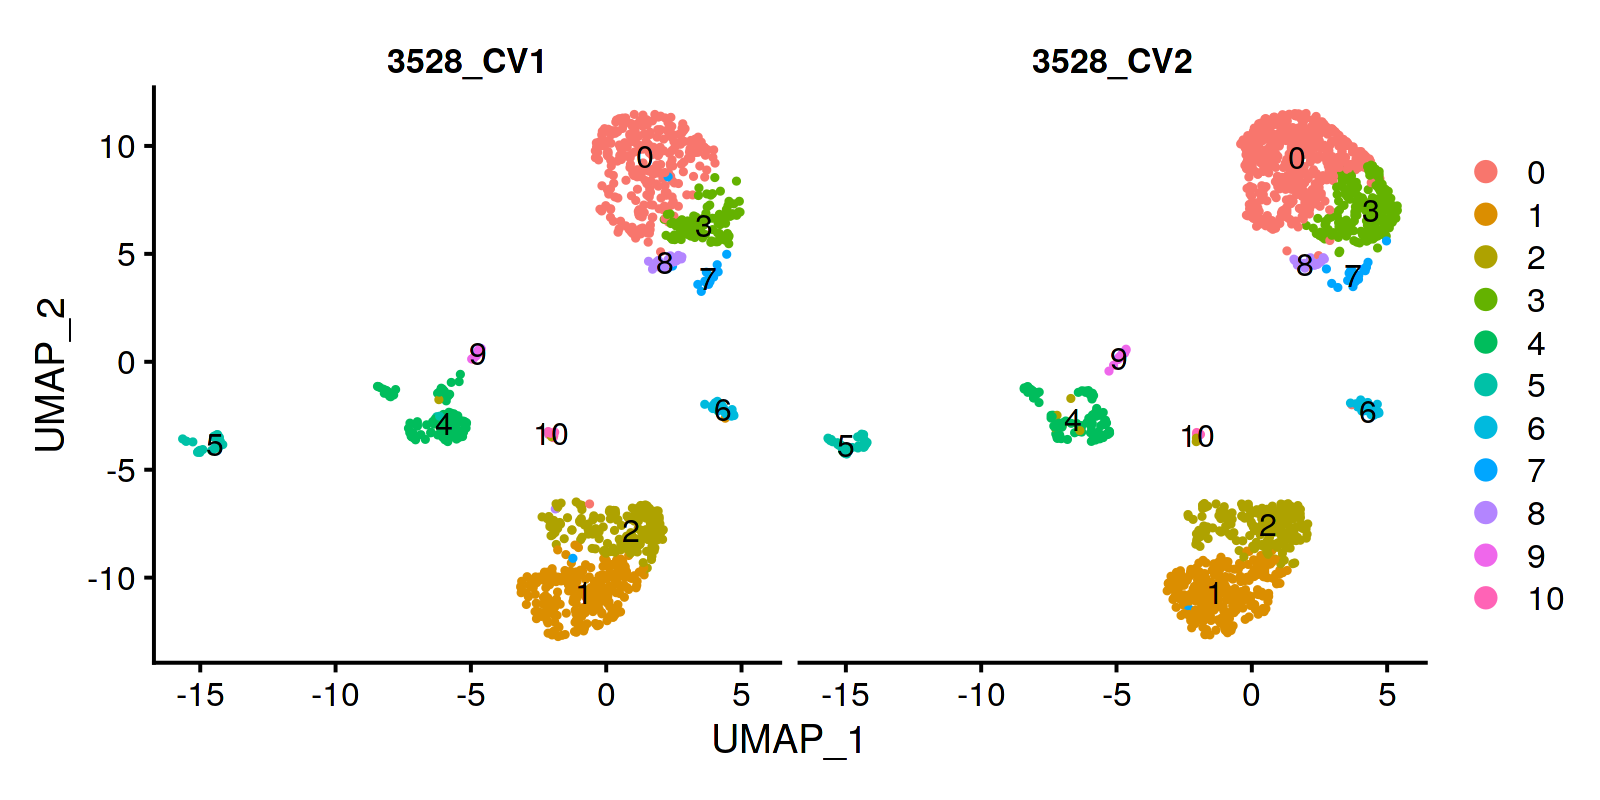

In [322]:
options(repr.plot.height = 4)
DimPlot(rna, reduction = "umap", label = TRUE, split.by = "library")

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
"The following requested variables were not found: SAMD"


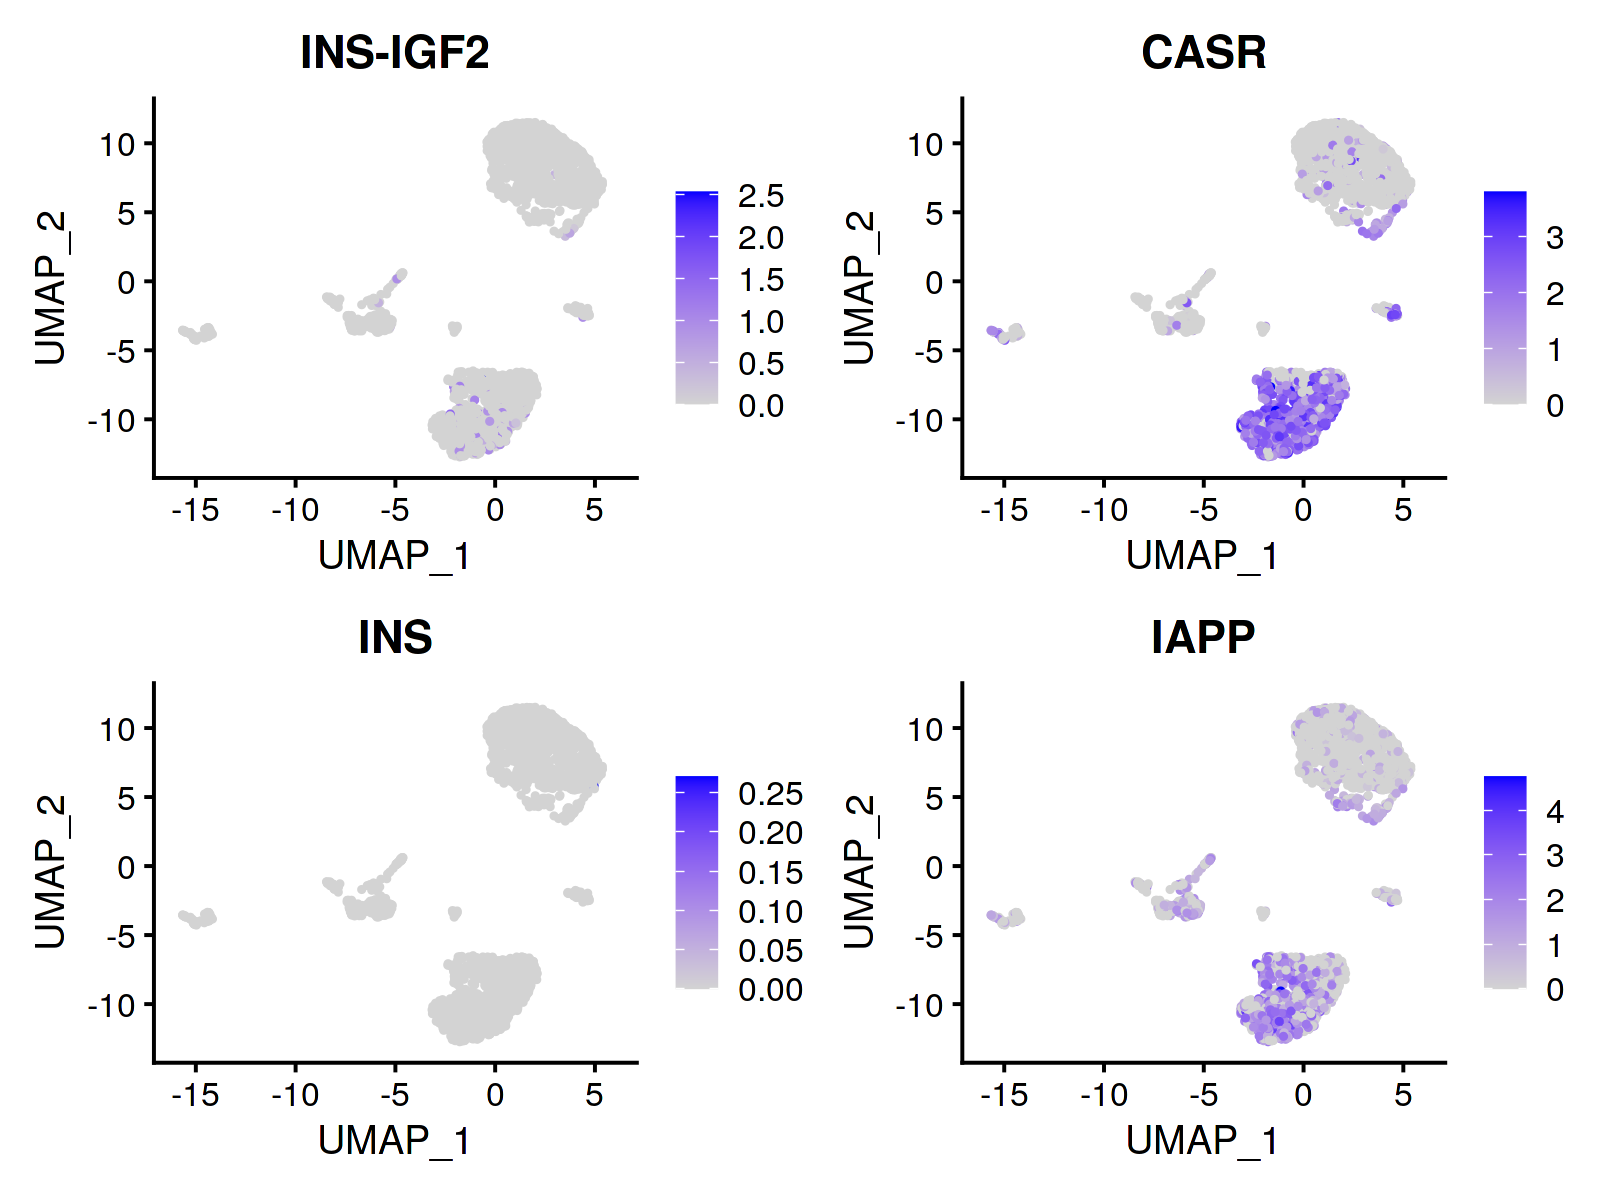

In [328]:
options(repr.plot.height = 6)
FeaturePlot(rna, c("INS-IGF2", "CASR", "SAMD", "INS", "IAPP"))

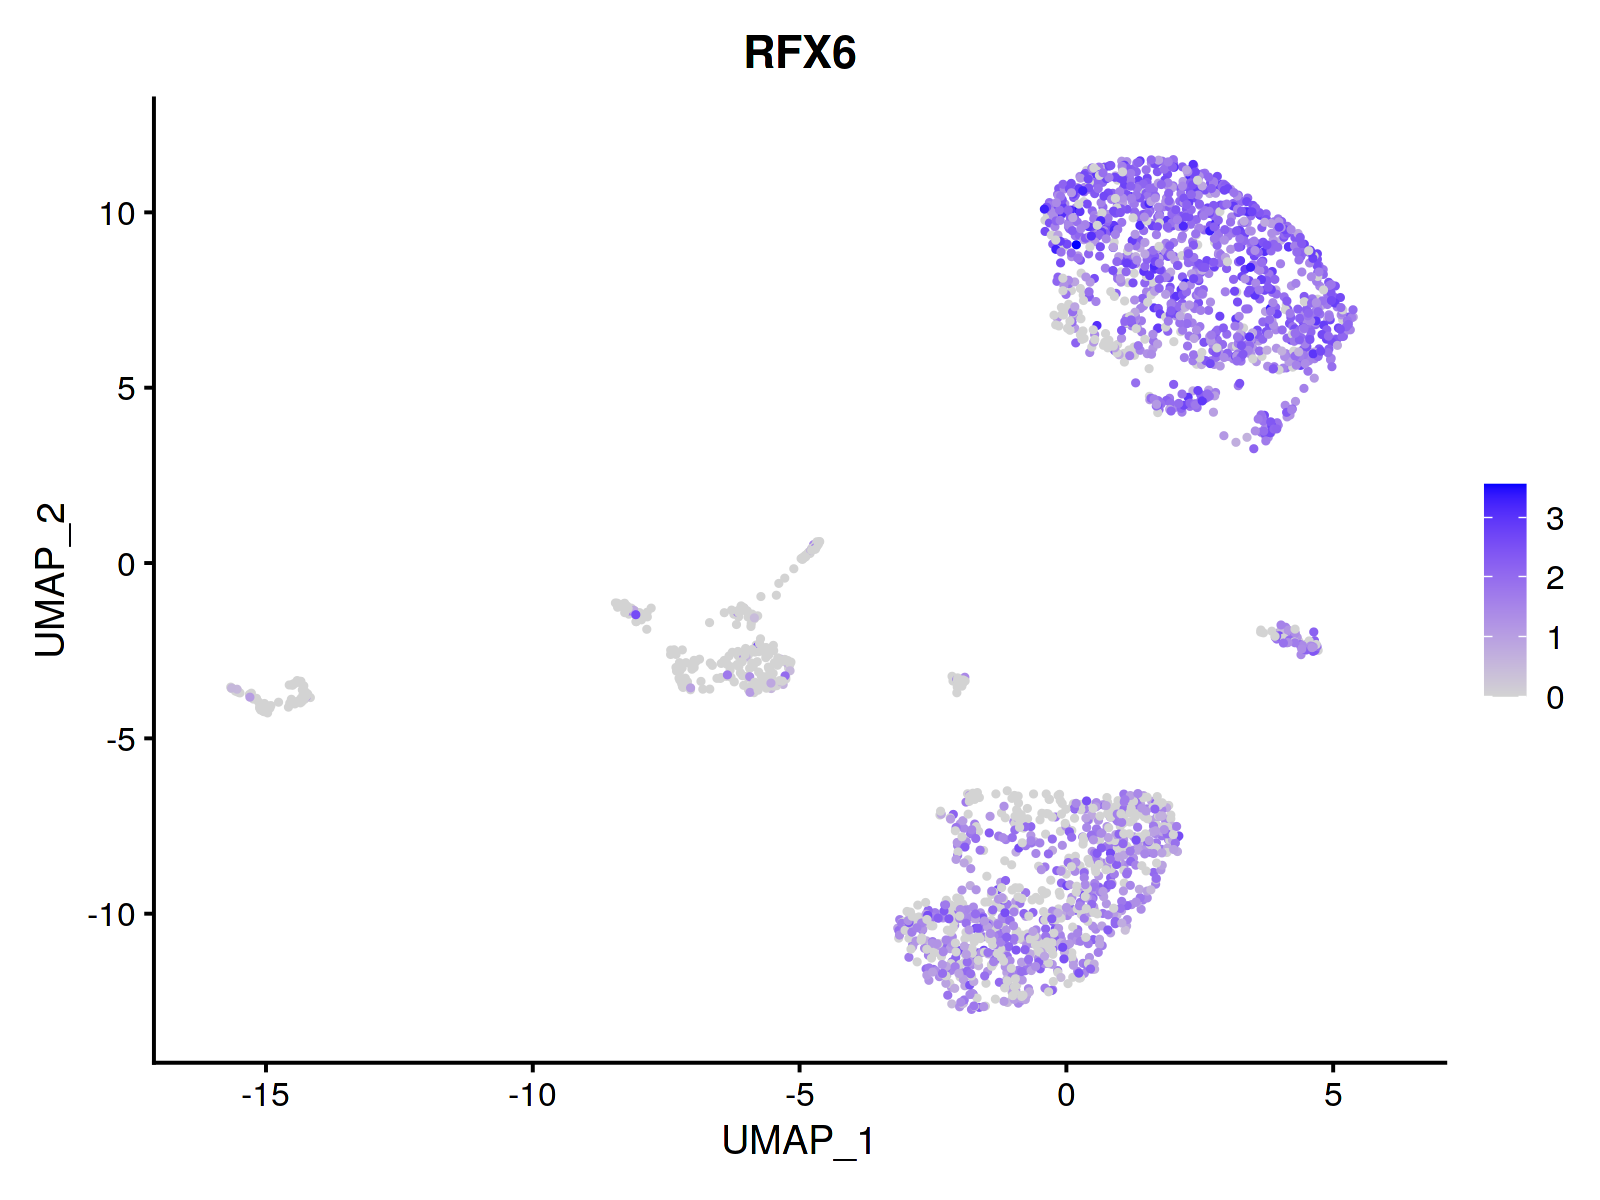

In [324]:
FeaturePlot(rna, c("RFX6"))

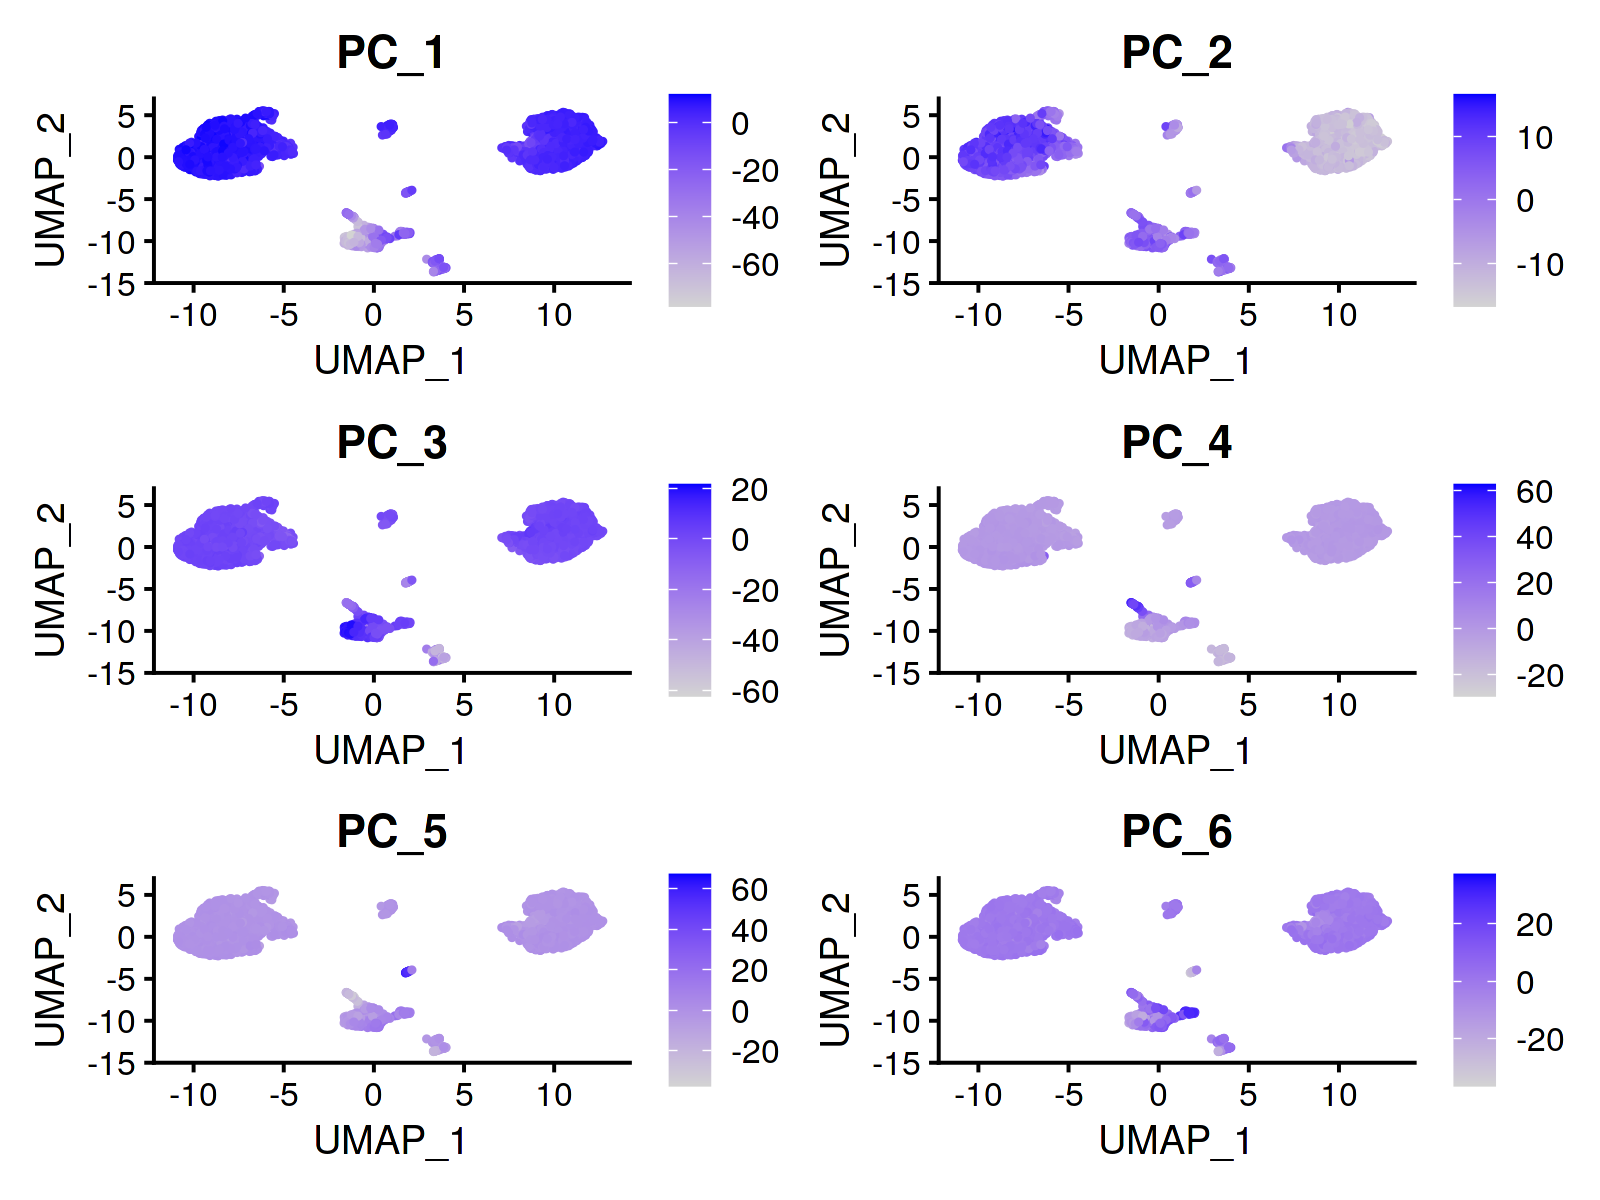

In [290]:
FeaturePlot(rna, c("PC_1", "PC_2", "PC_3", "PC_4", "PC_5", "PC_6"))

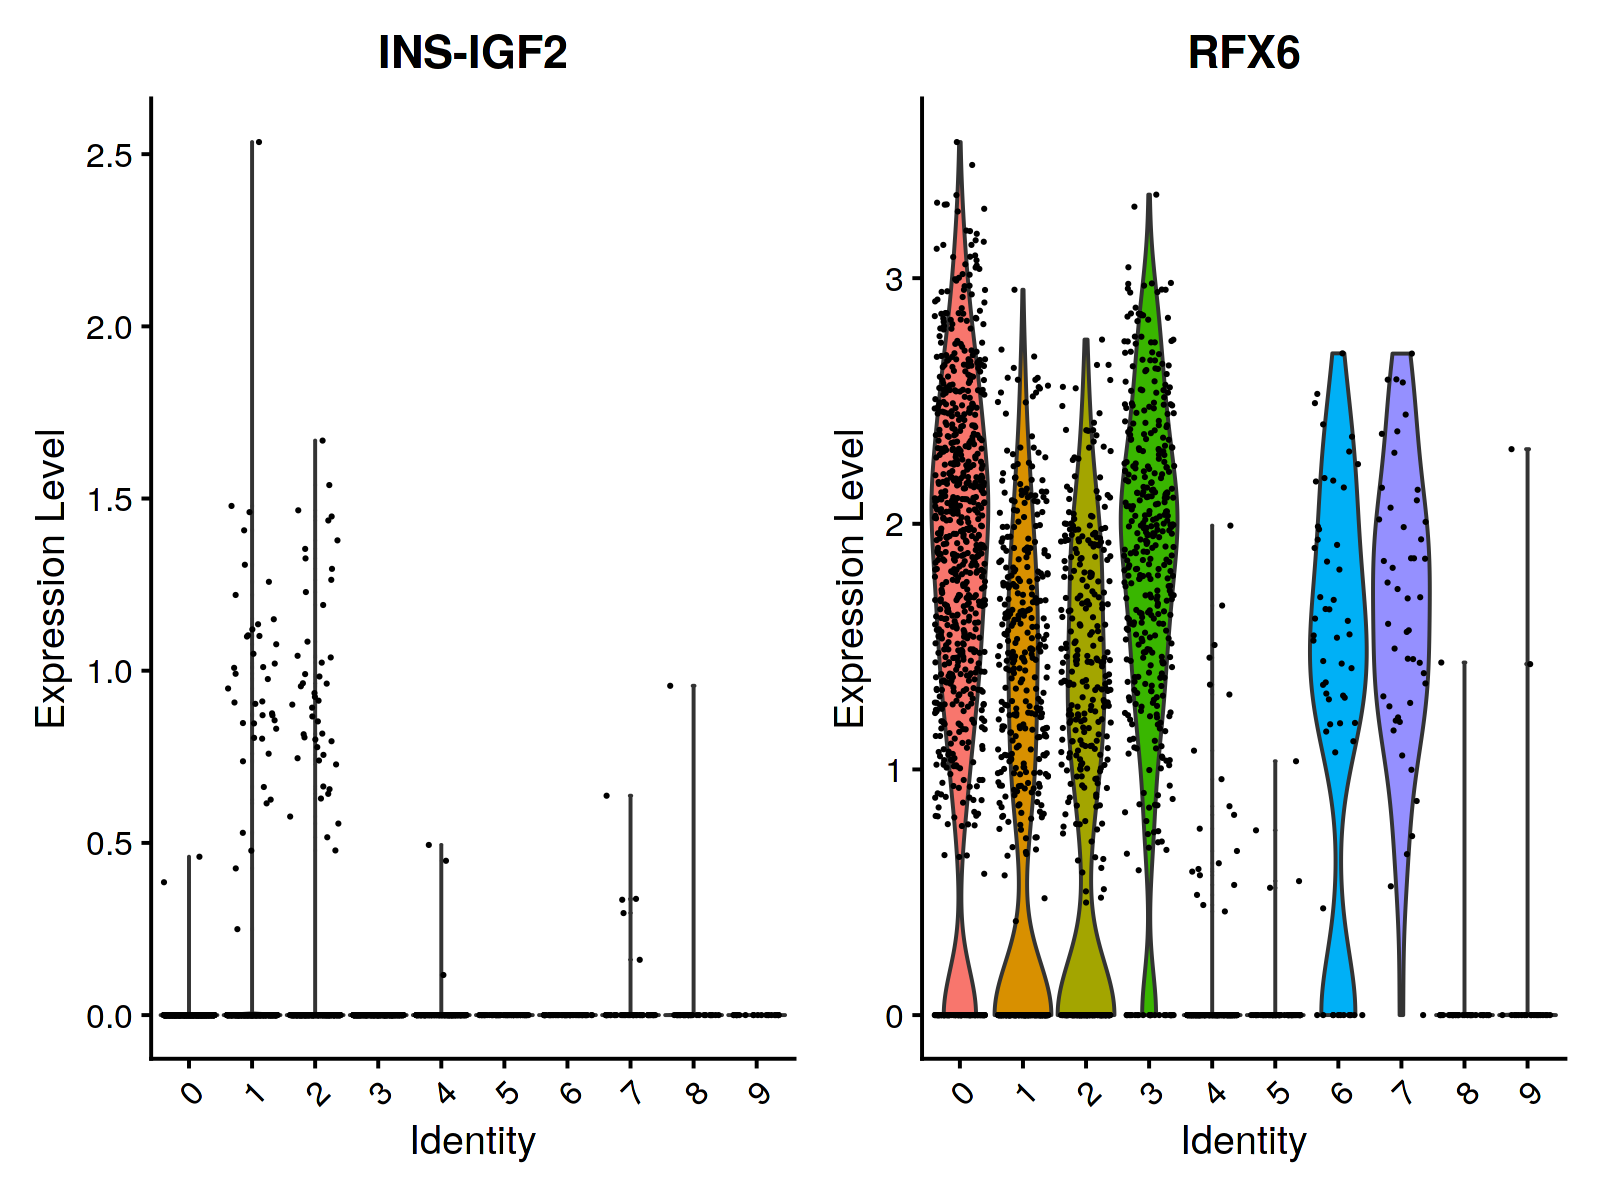

In [292]:
VlnPlot(rna, c("INS-IGF2", "RFX6"))

In [270]:
cluster_markers <- FindAllMarkers(rna, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



In [272]:
cluster_markers %>% group_by(cluster) %>% filter(cluster %in% 0:3) %>% slice_min(p_val, n = 5)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
4.318557e-227,1.960309,0.939,0.367,6.561183e-223,0,SLC35F4
5.595671e-218,1.944348,0.839,0.234,8.501503e-214,0,SPOCK3
3.287726e-205,1.873729,0.893,0.315,4.995042e-201,0,CSGALNACT1
1.704314e-203,1.581664,0.946,0.287,2.589364e-199,0,POU6F2
1.031023e-199,1.954105,0.829,0.240,1.566434e-195,0,PTPRT
3.097503e-286,2.931548,0.997,0.328,4.706036e-282,1,ZNF385D
4.636755e-282,2.840635,1.000,0.324,7.044622e-278,1,TRPM3
5.198220e-236,2.046409,0.942,0.249,7.897655e-232,1,CASR
1.035506e-222,2.537106,0.834,0.186,1.573244e-218,1,LRRTM3


# Using ATAC modality

In [77]:
# ATAC_HDFS <- Sys.glob("/lab/work/vivekrai/2021-06_pilot-rfx6/work/nuclei-qc/atac/*.hdf5")

In [113]:
# annotations <- rtracklayer::readGFFAsGRanges("/lab/work/vivekrai/2020-01_vanderbilt_rna/data/hg19_custom_ref/build/hg19-mCherry-mKate2.gtf")

In [118]:
# atac_objects <- list()

# for (f in ATAC_HDFS) {
#     counts <- load_hdf(f)
#     colnames(counts) <- unlist(lapply(strsplit(colnames((tmp)), ":"), function(x) { paste(x[1], x[2], x[3], sep = ":") }))
#     library <- gsub(".hdf5", "", basename(f))

#     rownames(counts) <- paste(library, rownames(counts), sep = "_")

#     atac <- Signac::CreateChromatinAssay(
#         counts = t(counts),
#         min.cells = 5,
#         sep = c(":", ":"),
#         annotation = annotations
#     )
#     atac_objects[[length(atac_objects) + 1]] <- atac
# }

# atac <- merge(atac_objects[[1]], atac_objects[[2]], project = "ATAC")

Warning message in Signac::CreateChromatinAssay(counts = t(counts), min.cells = 5, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"
Warning message in Signac::CreateChromatinAssay(counts = t(counts), min.cells = 5, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"

Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows

